In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
#import lhapdf
import matplotlib.pyplot as plt
from scipy.integrate import simps

In [2]:
############ Generating Pseudodata #################

def f(x):
    return (x**0.1)*((1-x)**0.3)

def Sk(k):
    return 2*k**2/(k**2 + 4)

def fx1kx2k(x1,x2,pT,k):
    return f(x1)*Sk(k)*f(x2)*Sk(pT-k)

x1vals = np.linspace(0.0001, 0.3, 10)
x2vals = np.linspace(0.1, 0.7, 10)
pTvals = np.linspace(0.1,2,10)

def Apseudo(x1,x2,pT):
    tempx1, tempx2, temppT, tempA = [], [], [], []
    kk = np.linspace(0.0001,2,50)
    for i in range(len(x1)):
        for j in range(len(x2)):
            tempx1.append(x1[i])
            tempx2.append(x2[j])
            temppT.append(pT[j])
            tempfx1kfx2k = simps(fx1kx2k(x1[i],x2[j],pT[j],kk), dx=(kk[1]-kk[0]))
            tempA.append(tempfx1kfx2k)
    return np.array(tempx1), np.array(tempx2), np.array(temppT), np.array(tempA)

x1Vals, x2Vals, pTVals, Avals = Apseudo(x1vals,x2vals,pTvals)

df = pd.DataFrame({'x1': x1Vals, 'x2': x2Vals, 'pT': pTVals, 'A': Avals})
df

,x1,x2,pT,A
0,0.0001,0.100000,0.100000,0.160846
1,0.0001,0.166667,0.311111,0.131994
2,0.0001,0.233333,0.522222,0.100706
3,0.0001,0.300000,0.733333,0.071227
4,0.0001,0.366667,0.944444,0.046604
...,...,...,...,...
95,0.3000,0.433333,1.155556,0.058371
96,0.3000,0.500000,1.366667,0.040853
97,0.3000,0.566667,1.577778,0.041525
98,0.3000,0.633333,1.788889,0.058735


In [3]:
Hidden_Layers=2
Nodes_per_HL=10
Learning_Rate = 0.0001
EPOCHS = 5

### Here we create models for each quark-flavor inputs are x and k ###
def create_nn_model(name, hidden_layers=Hidden_Layers, width=Nodes_per_HL, activation='relu'):
    inp = tf.keras.Input(shape=(2))
    x = tf.keras.layers.Dense(width, activation=activation)(inp)
    for i in range(hidden_layers-1):
        x = tf.keras.layers.Dense(width, activation=activation)(x)
    nnout = tf.keras.layers.Dense(1)(x)
    mod = tf.keras.Model(inp, nnout, name=name)
    return mod

def createModel_DY():
    x1 = tf.keras.Input(shape=(1), name='x1')
    x2 = tf.keras.Input(shape=(1), name='x2')
    qT = tf.keras.Input(shape=(1), name='qT')

    modnnu = create_nn_model('nnu')
    modnnubar = create_nn_model('nnubar')

    k_values = tf.linspace(0.0, 2.0, 50)  # Generate k values

    tmd_list = []  # List to store TMD values for each k value
    for k_val in k_values:      
        nnu_input = tf.keras.layers.Concatenate()([x1, qT*0 + k_val])
        nnubar_input = tf.keras.layers.Concatenate()([x2, qT - k_val])

        nnu_x1 = modnnu(nnu_input)
        nnubar_x2 = modnnubar(nnubar_input)

        tmd_list.append(tf.keras.layers.Multiply()([nnu_x1, nnubar_x2]))

    # Summing over all k values
    tmd_sum = tf.keras.layers.Add()(tmd_list)

    return tf.keras.Model([x1, x2, qT], tmd_sum)

TMD_Model_DY = createModel_DY()

In [4]:
TMD_Model_DY.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 qT (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 1)            0           ['qT[0][0]']                     
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 1)           0           ['qT[0][0]']                     
 )                                                                                                
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 1)           0           ['qT[0][0]']                 

 a)                                                                                               
                                                                                                  
 tf.math.multiply_27 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.math.multiply_28 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.math.multiply_29 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
          

 tf.math.subtract_1 (TFOpLambda  (None, 1)           0           ['qT[0][0]']                     
 )                                                                                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 1)           0           ['tf.math.multiply_2[0][0]']     
 mbda)                                                                                            
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 1)           0           ['qT[0][0]']                     
 )                                                                                                
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 1)           0           ['tf.math.multiply_3[0][0]']     
 mbda)    

                                                                                                  
 tf.math.subtract_15 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.__operators__.add_16 (TFOpL  (None, 1)           0           ['tf.math.multiply_16[0][0]']    
 ambda)                                                                                           
                                                                                                  
 tf.math.subtract_16 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.__oper

 ambda)                                                                                           
                                                                                                  
 tf.math.subtract_29 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.__operators__.add_30 (TFOpL  (None, 1)           0           ['tf.math.multiply_30[0][0]']    
 ambda)                                                                                           
                                                                                                  
 tf.math.subtract_30 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
          

 tf.__operators__.add_43 (TFOpL  (None, 1)           0           ['tf.math.multiply_43[0][0]']    
 ambda)                                                                                           
                                                                                                  
 tf.math.subtract_43 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)                                                                                               
                                                                                                  
 tf.__operators__.add_44 (TFOpL  (None, 1)           0           ['tf.math.multiply_44[0][0]']    
 ambda)                                                                                           
                                                                                                  
 tf.math.subtract_44 (TFOpLambd  (None, 1)           0           ['qT[0][0]']                     
 a)       

                                                                                                  
 concatenate_14 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_7[0][0]'] 
                                                                                                  
 concatenate_15 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_7[0][0]']     
                                                                                                  
 concatenate_16 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_8[0][0]'] 
                                                                                                  
 concatena

                                                                  'tf.math.subtract_20[0][0]']    
                                                                                                  
 concatenate_42 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_21[0][0]']
                                                                                                  
 concatenate_43 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_21[0][0]']    
                                                                                                  
 concatenate_44 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_22[0][0]']
          

 concatenate_69 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_34[0][0]']    
                                                                                                  
 concatenate_70 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_35[0][0]']
                                                                                                  
 concatenate_71 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_35[0][0]']    
                                                                                                  
 concatenate_72 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
          

                                                                                                  
 concatenate_97 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_48[0][0]']    
                                                                                                  
 concatenate_98 (Concatenate)   (None, 2)            0           ['x1[0][0]',                     
                                                                  'tf.__operators__.add_49[0][0]']
                                                                                                  
 concatenate_99 (Concatenate)   (None, 2)            0           ['x2[0][0]',                     
                                                                  'tf.math.subtract_49[0][0]']    
                                                                                                  
 nnu (Func

                                                                  'concatenate_45[0][0]',         
                                                                  'concatenate_47[0][0]',         
                                                                  'concatenate_49[0][0]',         
                                                                  'concatenate_51[0][0]',         
                                                                  'concatenate_53[0][0]',         
                                                                  'concatenate_55[0][0]',         
                                                                  'concatenate_57[0][0]',         
                                                                  'concatenate_59[0][0]',         
                                                                  'concatenate_61[0][0]',         
                                                                  'concatenate_63[0][0]',         
          

 multiply_18 (Multiply)         (None, 1)            0           ['nnu[18][0]',                   
                                                                  'nnubar[18][0]']                
                                                                                                  
 multiply_19 (Multiply)         (None, 1)            0           ['nnu[19][0]',                   
                                                                  'nnubar[19][0]']                
                                                                                                  
 multiply_20 (Multiply)         (None, 1)            0           ['nnu[20][0]',                   
                                                                  'nnubar[20][0]']                
                                                                                                  
 multiply_21 (Multiply)         (None, 1)            0           ['nnu[21][0]',                   
          

                                                                                                  
 multiply_46 (Multiply)         (None, 1)            0           ['nnu[46][0]',                   
                                                                  'nnubar[46][0]']                
                                                                                                  
 multiply_47 (Multiply)         (None, 1)            0           ['nnu[47][0]',                   
                                                                  'nnubar[47][0]']                
                                                                                                  
 multiply_48 (Multiply)         (None, 1)            0           ['nnu[48][0]',                   
                                                                  'nnubar[48][0]']                
                                                                                                  
 multiply_

In [5]:
# Define loss function and optimizer
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model = createModel_DY()
model.compile(optimizer=optimizer, loss=loss_function)

# Train the model on the entire dataset
history = model.fit([df['x1'],df['x2'],df['pT']], df['A'], epochs=50, batch_size=32, verbose=2)

Epoch 1/50
4/4 - 5s - loss: 0.0339 - 5s/epoch - 1s/step
Epoch 2/50
4/4 - 0s - loss: 0.0215 - 16ms/epoch - 4ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0173 - 12ms/epoch - 3ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0111 - 26ms/epoch - 6ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0108 - 32ms/epoch - 8ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0068 - 23ms/epoch - 6ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0074 - 24ms/epoch - 6ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0061 - 37ms/epoch - 9ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0036 - 25ms/epoch - 6ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0052 - 31ms/epoch - 8ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0025 - 23ms/epoch - 6ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0024 - 39ms/epoch - 10ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0027 - 15ms/epoch - 4ms/step
Epoch 14/50
4/4 - 0s - loss: 0.0016 - 30ms/epoch - 8ms/step
Epoch 15/50
4/4 - 0s - loss: 0.0021 - 21ms/epoch - 5ms/step
Epoch 16/50
4/4 - 0s - loss: 0.0017 - 23ms/epoch - 6ms/step
Epoch 17/50
4/4 - 0s - loss: 0.0016 - 41ms/epoch - 

4/4 [==============================] - 0s 6ms/step


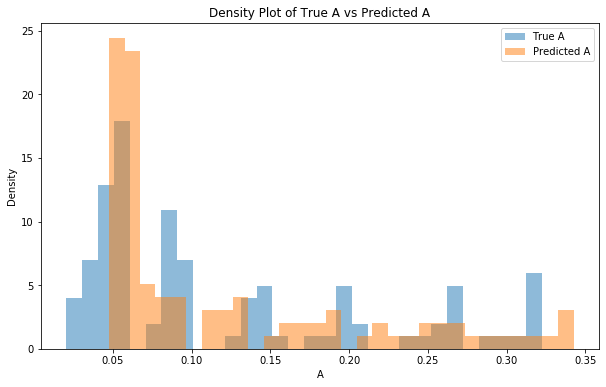

In [8]:
# Use the trained model to predict A values
predicted_A = model.predict([df['x1'],df['x2'],df['pT']])
true_A = df['A']

# Plot density distribution of true A values and predicted A values
plt.figure(figsize=(10, 6))
plt.hist(true_A, bins=30, alpha=0.5, density=True, label='True A')
plt.hist(predicted_A.flatten(), bins=30, alpha=0.5, density=True, label='Predicted A')
plt.title('Density Plot of True A vs Predicted A')
plt.xlabel('A')
plt.ylabel('Density')
plt.legend()
plt.show()

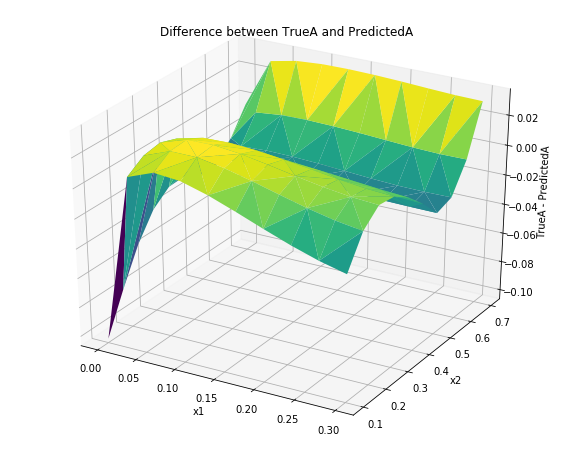

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Calculate the difference between true A and predicted A
difference_A = true_A - predicted_A.flatten()

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df['x1'], df['x2'], difference_A, cmap='viridis')

# Set labels and title
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('TrueA - PredictedA')
ax.set_title('Difference between TrueA and PredictedA')

plt.show()

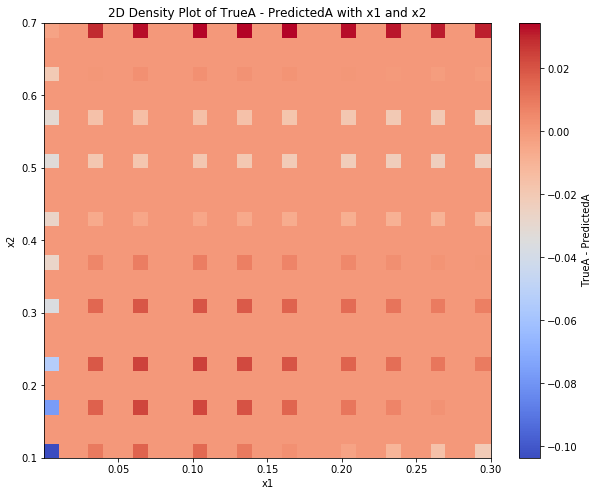

In [11]:
# Calculate the difference between true A and predicted A
difference_A = true_A - predicted_A.flatten()

# Plot 2D density plot
plt.figure(figsize=(10, 8))
plt.hist2d(df['x1'], df['x2'], bins=30, weights=difference_A, cmap='coolwarm')
plt.colorbar(label='TrueA - PredictedA')
plt.title('2D Density Plot of TrueA - PredictedA with x1 and x2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

4/4 [==============================] - 0s 2ms/step


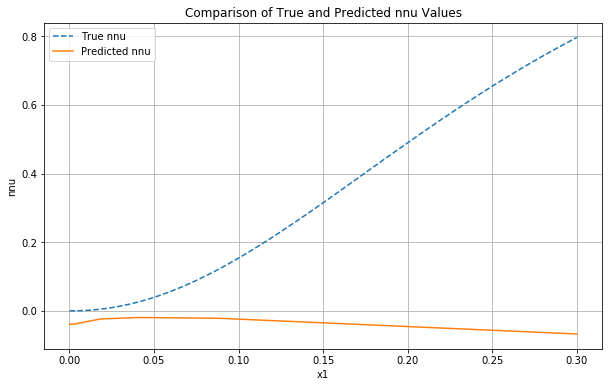

In [30]:

# Retrieve the nnu model from the trained model
modnnu = model.get_layer('nnu')

# Generate x1 values
x1_values = np.array(np.linspace(0.0001, 0.3, 100))
kk_values = np.array(np.linspace(0.0001, 2, 100))

# Calculate the true values using the function f(x1)*Sk(k)
def f(x):
    return (x**0.1) * ((1 - x)**0.3)

def Sk(k):
    return 2 * k**2 / (k**2 + 4)

true_values = f(x1_values) * Sk(kk_values)  


#tf.keras.layers.Concatenate()([x1, qT*0 + k_val])
concatenated_inputs = np.column_stack((x1_values,kk_values))
predicted_values = modnnu.predict(concatenated_inputs)

# 5. Plot the true and predicted nnu values for comparison
plt.figure(figsize=(10, 6))
plt.plot(x1_values, true_values, label='True nnu', linestyle='--')
plt.plot(x1_values, predicted_values, label='Predicted nnu')
plt.title('Comparison of True and Predicted nnu Values')
plt.xlabel('x1')
plt.ylabel('nnu')
plt.legend()
plt.grid(True)
plt.show()
